### Code for generating stack profiles along multiple datasets about a line
### Requires the rasters and polyline as input
#### Currently using Elevation as the index value (for the x axis) which is expected to be the last input in the *files* list, can use distance as well

In [13]:
#importing the libraries required for the evaluation
import numpy as np
import rasterio
from pygeotools.lib import malib, warplib, iolib,geolib
import numpy.ma as ma
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd

In [6]:
#The function used for clipping needs the filename rarther than the dataset for clippin, thus we warp the intial rasters to disk 
files=['01_02_.tif','02_03_.tif','03_04_.tif','Elevation_.tif'] #Elevation raster is last
warplib.diskwarp_multi_fn(files, res='max', extent='intersection',t_srs='first',r='cubic')#warping inputs to disk
count=len(files)


Warping all inputs to the following:
Resolution: 30.0
Extent: [517185.0, 2930092.5, 748507.5, 3139215.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: 01_02_.tif
nl: 6971 ns: 7711 res: 30.000
2 of 4: 02_03_.tif
nl: 6971 ns: 7711 res: 30.000
3 of 4: 03_04_.tif
nl: 6971 ns: 7711 res: 30.000
4 of 4: Elevation_.tif
nl: 6971 ns: 7711 res: 30.000


#### Clipping rasters to the extents along the input polyline

In [9]:
fn='Zemu.shp' #input shapefile (polyline)
i=0
while i < count:
    r=files[i]
    f=os.path.splitext(r)[0]+'_warp.tif'
    geolib.clip_raster_by_shp(f, fn)
    i=i+1

['clip_raster_by_shp.py', '01_02__warp.tif', 'Zemu.shp']
['clip_raster_by_shp.py', '02_03__warp.tif', 'Zemu.shp']
['clip_raster_by_shp.py', '03_04__warp.tif', 'Zemu.shp']
['clip_raster_by_shp.py', 'Elevation__warp.tif', 'Zemu.shp']


In [10]:
#List with updated filenames after clipping
i=0
updated_list=[]
while i < count:
    S=files[i]
    g=os.path.splitext(S)[0]+'_warp_shpclip.tif'
    updated_list.append(g)
    i=i+1
updated_list

['01_02__warp_shpclip.tif',
 '02_03__warp_shpclip.tif',
 '03_04__warp_shpclip.tif',
 'Elevation__warp_shpclip.tif']

In [11]:
#Warping the clipped files together
ds_list=warplib.memwarp_multi_fn(updated_list, res='max', extent='intersection',t_srs='first',r='cubic')


Warping all inputs to the following:
Resolution: 30.0
Extent: [517185.0, 2930085.0, 748515.0, 3139215.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: 01_02__warp_shpclip.tif
2 of 4: 02_03__warp_shpclip.tif
3 of 4: 03_04__warp_shpclip.tif
4 of 4: Elevation__warp_shpclip.tif


In [14]:
E=iolib.ds_getma(ds_list[-1])#Extracting the last entry of  ds_list, which is Elevation
#Creating dataframes of Input rasters with the index raster (here elevation), using common mask to keep the no. of data equal
i=0
while i < (count-1):
    A=iolib.ds_getma(ds_list[i])
    common_mask=malib.common_mask([A,E])#common mask for index and corresponding input raster
    #Final masking with the updated mask and compressing valid pixels only into 1 d np array
    E_A=ma.array(E,mask=common_mask)
    A_A=ma.array(A,mask=common_mask)
    E_F=ma.compressed(E_A)
    A_F=ma.compressed(A_A)
    #creating sucessive dataframes, take note of the *Global* function used to update variable name while looping
    s=files[i]
    e=os.path.splitext(s)[0]
    raw={'Elevation':E_F,
        e:A_F}
    globals()['df'+str(i)]=pd.DataFrame(raw, columns=['Elevation',e])
    #Sorting the obtained dataframes based on asscending elevation
    globals()['df_s'+str(i)]=(globals()['df'+str(i)]).sort_values(by='Elevation',ascending=True)
    i=i+1

In [15]:
Final=pd.merge(pd.merge(df_s0,df_s1,on='Elevation'),df_s2,on='Elevation')#merging the three dataframes, this is sort of hardcoded
                                                                         #for now, suggestions welcomed 
Indexed_F=Final.set_index('Elevation')#final dataframe indexed at Elevation
Indexed_F

,01_02_,02_03_,03_04_
Elevation,,,
4159.261719,1.107217,66.321777,12.034767
4165.567383,0.514692,58.503937,12.331426
4169.972656,0.601895,61.514389,12.573149
4179.349609,0.626422,64.824188,12.771370
4183.260254,1.612970,59.347893,12.804915
4196.337891,2.699858,62.955517,12.735391
4211.901855,3.374437,59.879383,12.365757
4212.682129,2.964637,47.743694,12.258940
4223.440918,2.864194,52.135342,11.790451


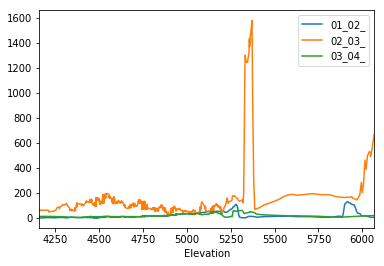

In [17]:
Indexed_F.plot() 


## Data is synthetic, dont judge the output!